# Small-delta KL div prediction

In our experiments, small parameterwise parameters systematically have a larger KL div than predicted. But the 2nd order prediction equation should be more accurate, not less, at small deltas.

Initial testing indicates that this might be a bias of the top-k KL divergence metric, which isn't present in the difference in xent vs baseline.

In [51]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch import tensor
from typing import Any

import weight_formats.experiments as E

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
fisher_sum = {run.config.model.split("/")[1]: run.summary.fisher for run in E.runs("20250423-fisher")}
weight_stats = {run.config.model.split("/")[1]: run.summary.weight_stats for run in E.runs("20250423-weight-stats")}
# Can't use this, as it doesn't always match the dataset used in 20250502-noise-sensitivity
# baseline_cross_entropy = {run.config.model.split("/")[1]: run.summary.cross_entropy for run in E.runs("20250506-results-baseline")}
runs = E.runs("20250502-noise-sensitivity")

In [ ]:
def get_row(run: E.AttrDict) -> dict[str, Any]:
    if run.meta.status == "finished" and "vision_model" not in run.config.test.parameter and "multi_modal_projector" not in run.config.test.parameter:
        model = run.config.model.split("/")[1]
        # if len(run.summary.cross_entropy) != len(baseline_cross_entropy[model]):
        #     print(model, len(run.summary.cross_entropy), len(baseline_cross_entropy[model]))
        return dict(
            model=model,
            scale=run.config.test.scale,
            parameter=run.config.test.parameter,
            fisher_sum=fisher_sum[model][run.config.test.parameter],
            rm2=weight_stats[model][run.config.test.parameter].rm2,
            kl_div=tensor(run.summary.kl_div).mean().item(),
            xent=tensor(run.summary.cross_entropy).mean().item(),
        )

df = pd.DataFrame.from_records(filter(None, map(get_row, runs)))
df["kl_div_prediction"] = 0.5 * (df.scale * df.rm2) ** 2 * df.fisher_sum
df["magnitude_prediction"] = 0.5 * (df.scale * df.rm2) ** 2
# Slight hack - use minimum xent instead of the true baseline
df = df.groupby("model").apply(lambda g: g.assign(xent_diff=g.xent - g.xent.min()), include_groups=False).reset_index().drop(columns="level_1")
df.head()

,model,scale,parameter,fisher_sum,rm2,kl_div,xent,kl_div_prediction,magnitude_prediction,xent_diff
0,Llama-3.1-8B,0.25,model.embed_tokens.weight,3294.044900,0.010615,0.012326,1.765309,0.011599,0.000004,0.007982
1,Llama-3.1-8B,0.25,model.layers.0.self_attn.q_proj.weight,3.408715,0.018771,0.001033,1.757452,0.000038,0.000011,0.000125
2,Llama-3.1-8B,0.25,model.layers.0.self_attn.k_proj.weight,6.670500,0.027073,0.001102,1.757326,0.000153,0.000023,0.000000
3,Llama-3.1-8B,0.25,model.layers.0.self_attn.v_proj.weight,5148.153300,0.007257,0.010293,1.763561,0.008472,0.000002,0.006234
4,Llama-3.1-8B,0.25,model.layers.0.self_attn.o_proj.weight,744.257690,0.008376,0.002572,1.759005,0.001632,0.000002,0.001678


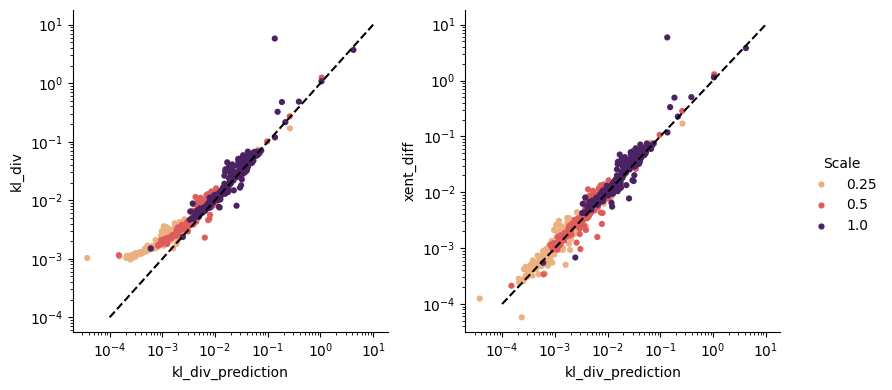

In [49]:
_, axs = plt.subplots(ncols=2, figsize=(8, 4))
for ylabel, ax in zip(["kl_div", "xent_diff"], axs):
    sns.scatterplot(data=df[df.model == "Llama-3.1-8B"], y=ylabel, x="kl_div_prediction", hue="scale", palette="flare", lw=0, s=20, ax=ax)
    ax.plot([10**-4, 10], [10**-4, 10], "k--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend_.remove()
ax.figure.legend(*axs[0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1.0, 0.5), title="Scale")
plt.tight_layout()

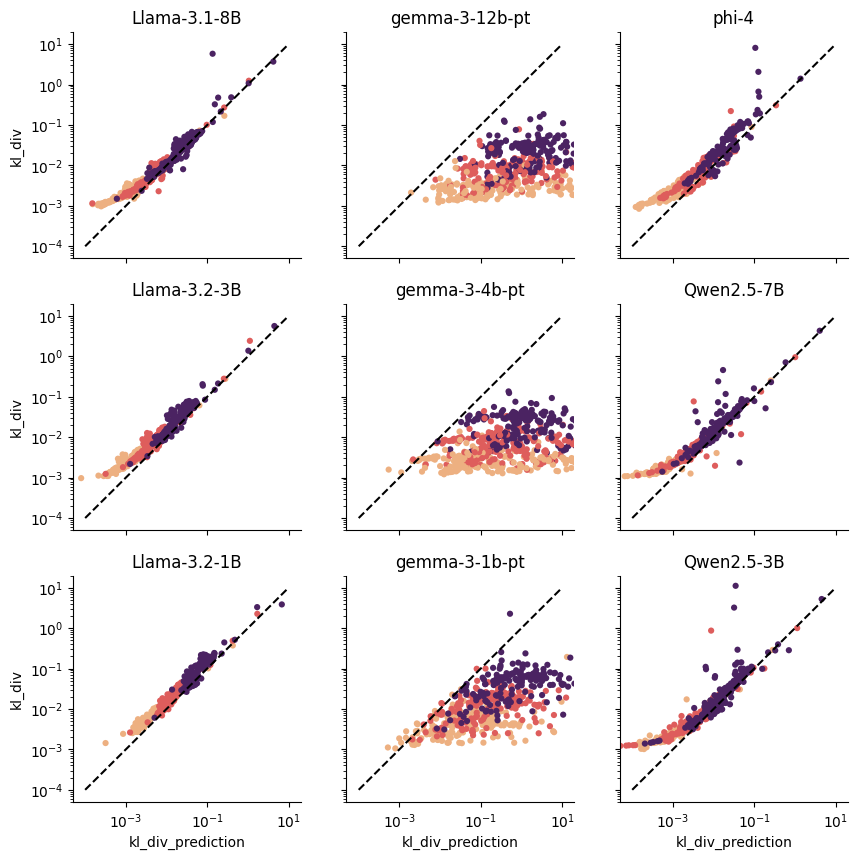

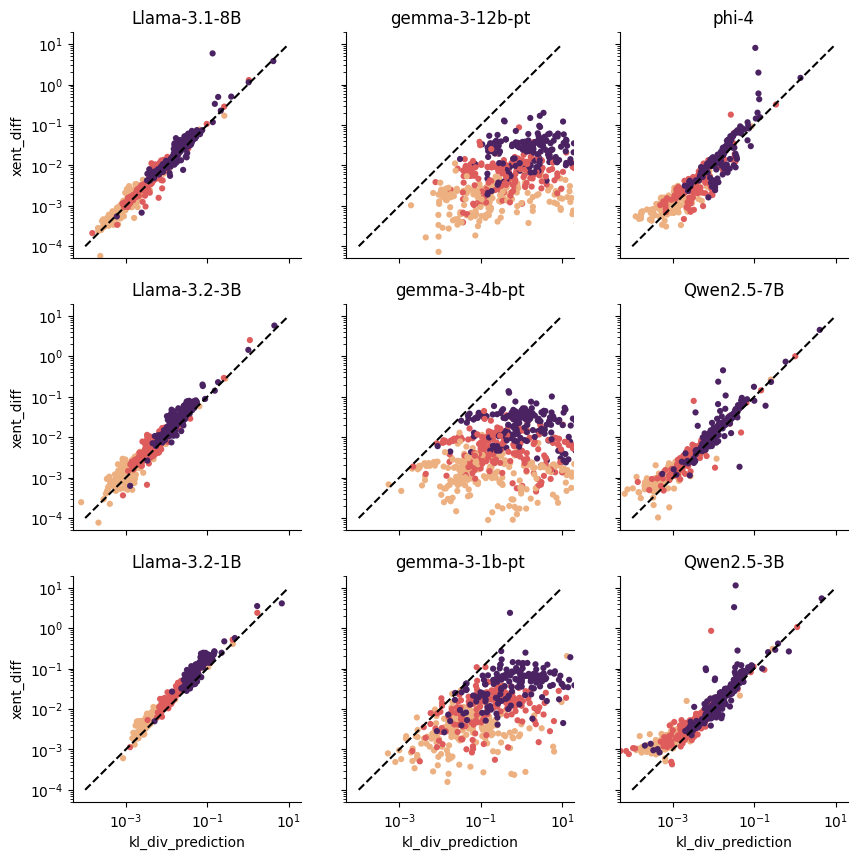

In [58]:
MODEL_ORDER_GRID = ["Llama-3.1-8B", "gemma-3-12b-pt", "phi-4",
                    "Llama-3.2-3B", "gemma-3-4b-pt", "Qwen2.5-7B",
                    "Llama-3.2-1B", "gemma-3-1b-pt", "Qwen2.5-3B"]

for ylabel in ["kl_div", "xent_diff"]:
    _, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharex=True, sharey=True)
    for model, ax in zip(MODEL_ORDER_GRID, axs.flatten()):
        sns.scatterplot(data=df[df.model == model], y=ylabel, x="kl_div_prediction", hue="scale", palette="flare", lw=0, s=20, ax=ax)
        ax.plot([10**-4, 10], [10**-4, 10], "k--")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.legend_.remove()
        ax.set_xlim((10**-4 / 2, 10 * 2))
        ax.set_ylim((10**-4 / 2, 10 * 2))
        ax.set_title(model)

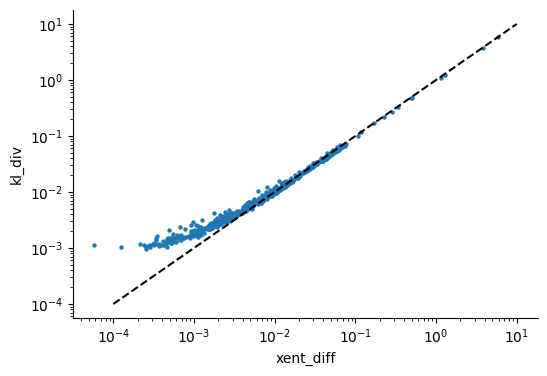

In [67]:
_, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df[df.model == "Llama-3.1-8B"], y="kl_div", x="xent_diff", lw=0, s=10, ax=ax)
ax.plot([10**-4, 10], [10**-4, 10], "k--")
ax.set_xscale("log")
ax.set_yscale("log")